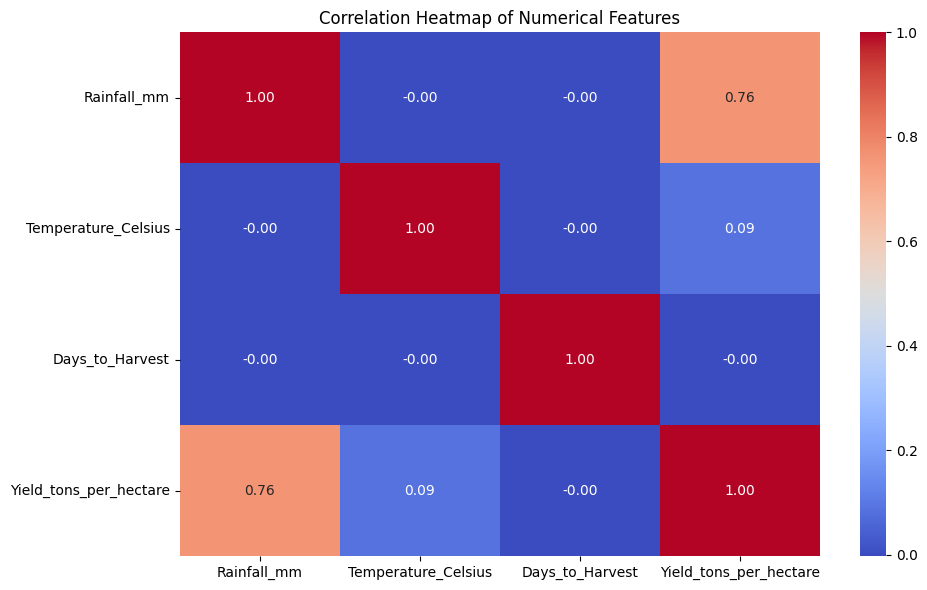

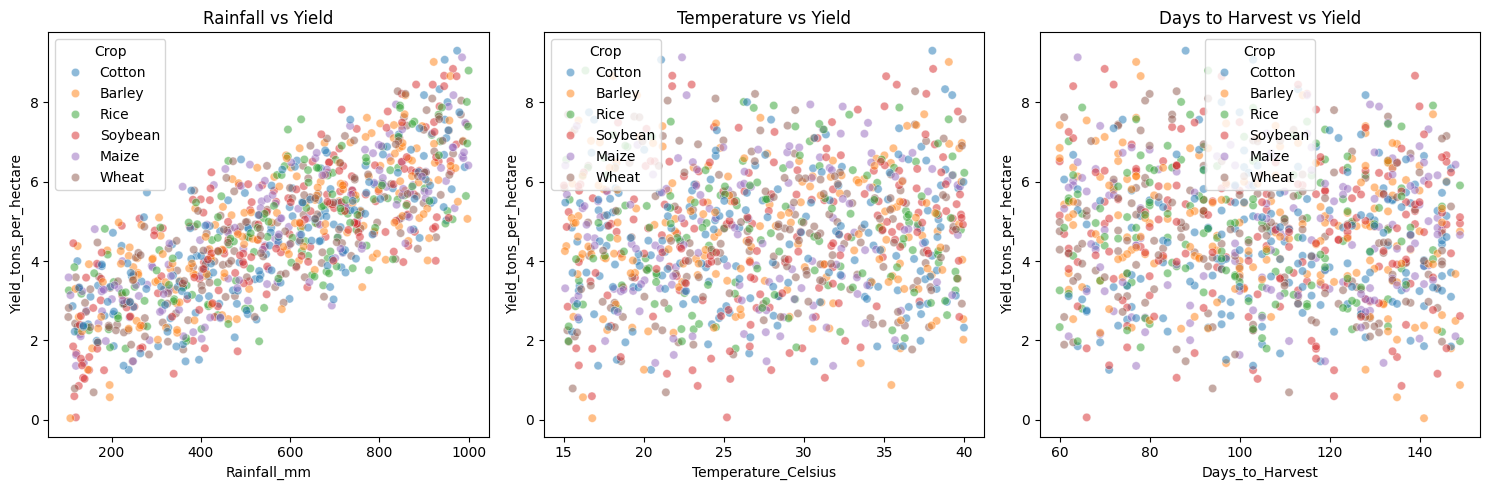

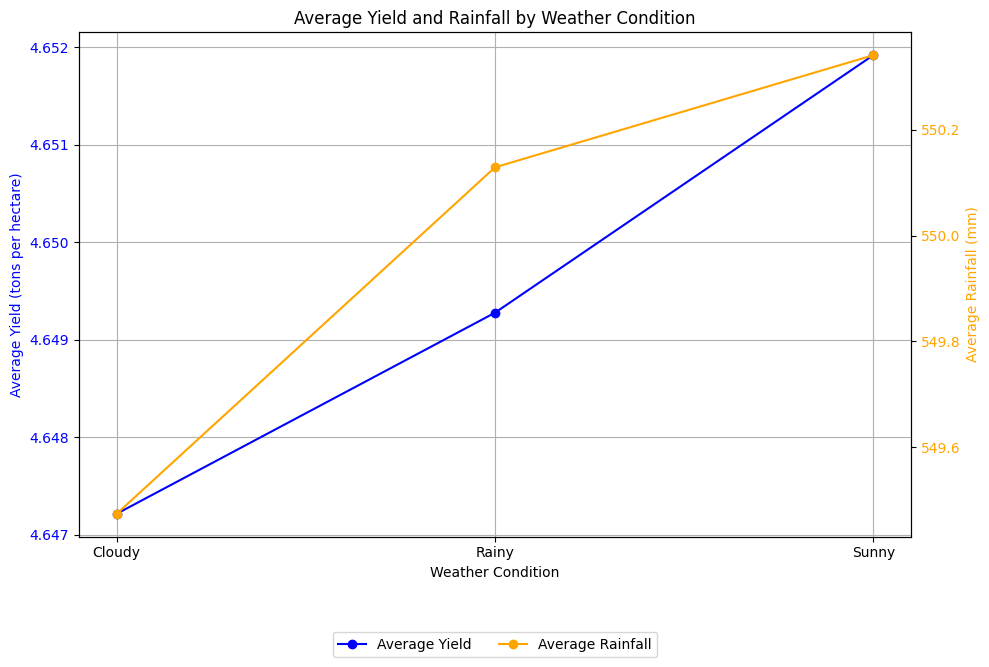

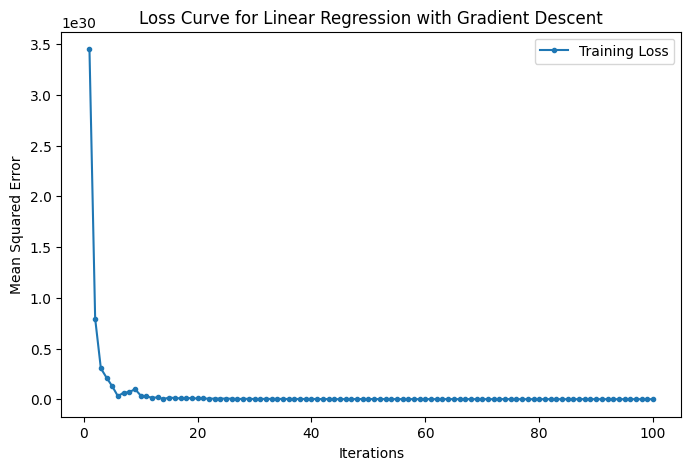


Model Evaluation Results:
Linear Regression (SGD):
  MAE: 10180780265001.0977
  MSE: 109199086954361954565619712.0000
  R2: -37877593828326444898451456.0000

Decision Tree:
  MAE: 0.4018
  MSE: 0.2537
  R2: 0.9120

Random Forest:
  MAE: 0.4002
  MSE: 0.2516
  R2: 0.9127

Best model saved as 'best_model.pkl' and compressed as 'best_model.pkl.gz'.

Example Prediction: 6.23 tons per hectare


C:\Users\ISARO\AppData\Local\Temp\ipykernel_15600\2888920063.py:263: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance.head(10), x='importance', y='feature', palette='viridis')


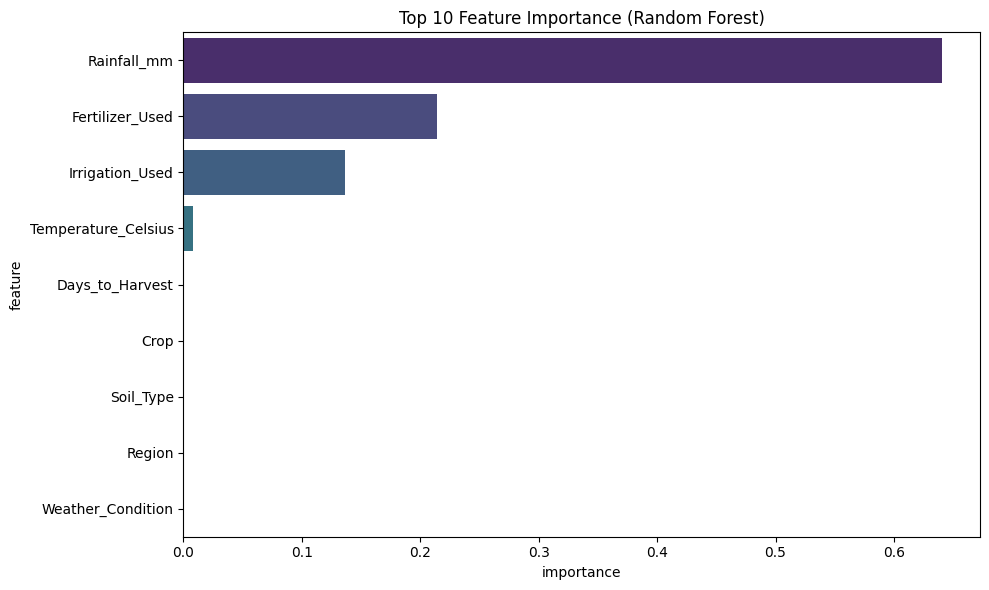


Feature Importance:
               feature  importance
3          Rainfall_mm    0.640651
5      Fertilizer_Used    0.214186
6      Irrigation_Used    0.136553
4  Temperature_Celsius    0.008386
8      Days_to_Harvest    0.000133
2                 Crop    0.000030
1            Soil_Type    0.000029
0               Region    0.000019
7    Weather_Condition    0.000013


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gzip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function 1: Preprocess the data
def preprocess_data(data):
    """
    Preprocess the crop yield dataset by encoding categorical features and converting boolean columns.
    """
    # Convert Fertilizer_Used and Irrigation_Used from TRUE/FALSE strings to integers (1/0)
    data['Fertilizer_Used'] = data['Fertilizer_Used'].astype(str).str.upper().map({'TRUE': 1, 'FALSE': 0})
    data['Irrigation_Used'] = data['Irrigation_Used'].astype(str).str.upper().map({'TRUE': 1, 'FALSE': 0})

    # Encode categorical variables
    label_encoder_region = LabelEncoder()
    data['Region'] = label_encoder_region.fit_transform(data['Region'])

    label_encoder_soil = LabelEncoder()
    data['Soil_Type'] = label_encoder_soil.fit_transform(data['Soil_Type'])

    label_encoder_crop = LabelEncoder()
    data['Crop'] = label_encoder_crop.fit_transform(data['Crop'])

    label_encoder_weather = LabelEncoder()
    data['Weather_Condition'] = label_encoder_weather.fit_transform(data['Weather_Condition'])

    return (data, label_encoder_region, label_encoder_soil, label_encoder_crop, label_encoder_weather)

# Function 2: Create visualizations
def create_visualizations(data):
    """
    Create visualizations to explore the dataset, using a subset of the data for scatter plots.
    """
    # Randomly sample 10% of the data (or 1,000 rows, whichever is smaller) for scatter plots
    
    sample_size = min(1000, int(len(data) * 0.1))
    data_sample = data.sample(n=sample_size, random_state=42)

    # 1. Correlation Heatmap (use full data since it doesn't plot individual points)
    plt.figure(figsize=(10, 6))
    numerical_data = data[['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest', 'Yield_tons_per_hectare']]
    correlation = numerical_data.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numerical Features')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()
    plt.close()

    # 2. Feature Relationships with Yield (use sampled data for scatter plots)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.scatterplot(data=data_sample, x='Rainfall_mm', y='Yield_tons_per_hectare', hue='Crop', alpha=0.5)
    plt.title('Rainfall vs Yield')

    plt.subplot(1, 3, 2)
    sns.scatterplot(data=data_sample, x='Temperature_Celsius', y='Yield_tons_per_hectare', hue='Crop', alpha=0.5)
    plt.title('Temperature vs Yield')

    plt.subplot(1, 3, 3)
    sns.scatterplot(data=data_sample, x='Days_to_Harvest', y='Yield_tons_per_hectare', hue='Crop', alpha=0.5)
    plt.title('Days to Harvest vs Yield')

    plt.tight_layout()
    plt.savefig('feature_relationships.png')
    plt.show()
    plt.close()

    # 3. Average Yield and Rainfall by Weather Condition (use full data since it aggregates)
    weather_yield = data.groupby('Weather_Condition').agg({
        'Yield_tons_per_hectare': 'mean',
        'Rainfall_mm': 'mean'
    }).reset_index()

    # Create a plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Average Yield on the first y-axis
    ax1.plot(weather_yield['Weather_Condition'], weather_yield['Yield_tons_per_hectare'], 
             label='Average Yield', color='blue', marker='o')
    ax1.set_xlabel('Weather Condition')
    ax1.set_ylabel('Average Yield (tons per hectare)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Create a second y-axis for Average Rainfall
    ax2 = ax1.twinx()
    ax2.plot(weather_yield['Weather_Condition'], weather_yield['Rainfall_mm'], 
             label='Average Rainfall', color='orange', marker='o')
    ax2.set_ylabel('Average Rainfall (mm)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Add title and legend
    plt.title('Average Yield and Rainfall by Weather Condition')
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.tight_layout()
    plt.savefig('weather_yield_pattern.png', bbox_inches='tight')
    plt.show()
    plt.close()

# Function 3: Train and evaluate models
def train_evaluate_models(X, y):
    """
    Train and evaluate Linear Regression (SGD), Decision Tree, and Random Forest models.
    Return the best model based on R2 score.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Linear Regression with Gradient Descent
    lr_model = SGDRegressor(max_iter=1000, learning_rate="optimal", random_state=42)
    train_losses = []
    for i in range(100):
        lr_model.partial_fit(X_train, y_train)
        y_train_pred = lr_model.predict(X_train)
        train_losses.append(mean_squared_error(y_train, y_train_pred))

    # Plot loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 101), train_losses, label='Training Loss', marker='o', markersize=3, linestyle='-')
    plt.xlabel("Iterations")
    plt.ylabel("Mean Squared Error")
    plt.title("Loss Curve for Linear Regression with Gradient Descent")
    plt.legend()
    plt.savefig('loss_curve.png')
    plt.show()
    plt.close()

    # Train Decision Tree Model
    dt_model = DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42)
    dt_model.fit(X_train, y_train)

    # Train Random Forest Model with reduced parameters
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, n_jobs=-1, random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred_lr = lr_model.predict(X_test)
    y_pred_dt = dt_model.predict(X_test)
    y_pred_rf = rf_model.predict(X_test)

    # Evaluate models
    results = {}
    best_score = -np.inf
    best_model = None
    best_model_name = ""

    for model_name, y_pred in [('Linear Regression (SGD)', y_pred_lr), 
                               ('Decision Tree', y_pred_dt), 
                               ('Random Forest', y_pred_rf)]:
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[model_name] = {'MAE': mae, 'MSE': mse, 'R2': r2}

        if r2 > best_score:
            best_score = r2
            best_model = {'Linear Regression (SGD)': lr_model, 'Decision Tree': dt_model, 'Random Forest': rf_model}[model_name]
            best_model_name = model_name

    return {'model': best_model, 'model_name': best_model_name}, results

# Function 4: Make a prediction
def make_prediction(model_info, label_encoders, input_data):
    """
    Make a prediction using the best model.
    """
    model = model_info['model']
    label_encoder_region, label_encoder_soil, label_encoder_crop, label_encoder_weather = label_encoders

    # Ensure input data is a DataFrame
    if not isinstance(input_data, pd.DataFrame):
        input_data = pd.DataFrame([input_data])

    # Encode categorical variables
    input_data['Region'] = label_encoder_region.transform(input_data['Region'])
    input_data['Soil_Type'] = label_encoder_soil.transform(input_data['Soil_Type'])
    input_data['Crop'] = label_encoder_crop.transform(input_data['Crop'])
    input_data['Weather_Condition'] = label_encoder_weather.transform(input_data['Weather_Condition'])

    # Convert Fertilizer_Used and Irrigation_Used to integers (1/0)
    input_data['Fertilizer_Used'] = input_data['Fertilizer_Used'].astype(str).str.upper().map({'TRUE': 1, 'FALSE': 0})
    input_data['Irrigation_Used'] = input_data['Irrigation_Used'].astype(str).str.upper().map({'TRUE': 1, 'FALSE': 0})

    # Select features in the correct order
    X = input_data[['Region', 'Soil_Type', 'Crop', 'Rainfall_mm', 'Temperature_Celsius', 
                    'Fertilizer_Used', 'Irrigation_Used', 'Weather_Condition', 'Days_to_Harvest']]

    # Make prediction
    prediction = model.predict(X)
    return prediction[0]

# Main execution
if __name__ == "__main__":
    # Load data
    data = pd.read_csv('crop_yield.csv', 
                       dtype={'Fertilizer_Used': 'object', 'Irrigation_Used': 'object'})

    # Create visualizations (using the original data before encoding)
    create_visualizations(data)

    # Preprocess data
    processed_data, label_encoder_region, label_encoder_soil, label_encoder_crop, label_encoder_weather = preprocess_data(data.copy())

    # Prepare features and target
    X = processed_data[['Region', 'Soil_Type', 'Crop', 'Rainfall_mm', 'Temperature_Celsius', 
                        'Fertilizer_Used', 'Irrigation_Used', 'Weather_Condition', 'Days_to_Harvest']]
    y = processed_data['Yield_tons_per_hectare']

    # Train and evaluate models
    model_info, results = train_evaluate_models(X, y)

    # Print evaluation results
    print("\nModel Evaluation Results:")
    for model_name, metrics in results.items():
        print(f"{model_name}:")
        print(f"  MAE: {metrics['MAE']:.4f}")
        print(f"  MSE: {metrics['MSE']:.4f}")
        print(f"  R2: {metrics['R2']:.4f}\n")

    # Save the best model and label encoders
    with open("best_model.pkl", "wb") as model_file:
        pickle.dump({
            'model': model_info['model'],
            'model_name': model_info['model_name'],
            'label_encoder_region': label_encoder_region,
            'label_encoder_soil': label_encoder_soil,
            'label_encoder_crop': label_encoder_crop,
            'label_encoder_weather': label_encoder_weather
        }, model_file)

    # Compress the model file
    with open("best_model.pkl", "rb") as f_in:
        with gzip.open("best_model.pkl.gz", "wb") as f_out:
            f_out.writelines(f_in)

    print("Best model saved as 'best_model.pkl' and compressed as 'best_model.pkl.gz'.")

    # Example prediction
    example_data = data.drop('Yield_tons_per_hectare', axis=1).iloc[0].to_dict()
    label_encoders = (label_encoder_region, label_encoder_soil, label_encoder_crop, label_encoder_weather)
    prediction = make_prediction(model_info, label_encoders, example_data)
    print(f"\nExample Prediction: {prediction:.2f} tons per hectare")

    # Feature importance for Random Forest (if applicable)
    if isinstance(model_info['model'], RandomForestRegressor):
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model_info['model'].feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=importance.head(10), x='importance', y='feature', palette='viridis')
        plt.title('Top 10 Feature Importance (Random Forest)')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()
        print("\nFeature Importance:")
        print(importance.head(10))